# Window-Based Detection using KAZE Descriptor Featuring Matching

In [39]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.patches as patches
import cv2
import os
import time
from IPython.display import clear_output
from sklearn.utils import shuffle
from sklearn import metrics as sk_metrics
from sklearn.model_selection import RandomizedSearchCV
import pickle as pkl
import scipy.ndimage as ndimage

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
import xgboost

from dataset import *
from descriptor import *
from SlidingWindow import *
from BagOfWords import *
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarningWarning)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [261]:
# Global Variables
curr_wd = os.getcwd()
example_path = os.path.join(curr_wd, 'datasets/', 'JPEGImages/', '004.jpg')
provided_annot_path = os.path.join(curr_wd, 'cache_anno/', 'classification', 'provided_annots.pkl')

# File path for BOVW
bovw_file_path = os.path.join(curr_wd, 'bovw/')
bovw_file_path_waldo = os.path.join(bovw_file_path, 'waldo/')
bovw_kaze_file_path = os.path.join(bovw_file_path_waldo, 'bovw_kaze_80.pkl')
bovw_sift_file_path = os.path.join(bovw_file_path_waldo, 'bovw_sift_80.pkl')
bovw_brisk_file_path = os.path.join(bovw_file_path_waldo, 'bovw_brisk_80.pkl')

# File path for Classifiers
model_file_path = os.path.join(curr_wd, 'models/')
model_file_path_waldo = os.path.join(model_file_path, 'waldo/')

# File path for extra data
extra_path = os.path.join(curr_wd, 'datasets/', 'JPEGImages/', 'extras')
extra_path_positives = os.path.join(extra_path, 'positives/')
extra_path_negatives = os.path.join(extra_path, 'negatives/')

# Descriptor type to use
desc_type = 'kaze'
num_clusters = 80

with open(provided_annot_path, 'rb') as f:
    provided_annots = pickle.load(f)

### Load Dataset

Loads the patches from the `datasets/train/positives` and `datasets/train/extra` as training data for classifier model. The patches are in the type `ndarray`
<br> *Detection classes allowed:* </br>
- **waldo_face_front** </br>
- **waldo_face_side** </br>
- **waldo_body_full** </br>
- **waldo_body_half** </br>
- **wenda_face_front** </br>
- **wenda_body_full** </br>
- **wenda_body_half** </br>
- **wizard_face_front** </br>
- **wizard_body_full** </br>
- **wizard_body_half** </br>
- **other_face_front** </br>
- **other_body_full** </br>
- **other_body_half**</br>

In [6]:
# Load data from all poses for current detection class
detection_class = 'waldo'
face_front = detection_class + '_face_front'
face_side = detection_class + '_face_side'
body_full = detection_class + '_body_full'
body_half = detection_class + '_body_half'

other_face_front = 'other_face_front'
face_side = detection_class + '_face_side'
other_body_full = 'other_body_full'
other_body_half = 'other_body_half'

# Load data for front face
print('Loading data for front face')
detection_type = [face_front]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_ff, valid_instances_ff = list(train_loader), list(valid_loader)

# Load data for side face
print('Loading data for side face')
detection_type = [face_side]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_sf, valid_instances_sf = list(train_loader), list(valid_loader)

# Load data for full body
print('Loading data for full body')
detection_type = [body_full]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_bf, valid_instances_bf = list(train_loader), list(valid_loader)

# Load data for half body
print('Loading data for half body')
detection_type = [body_half]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_bh, valid_instances_bh = list(train_loader), list(valid_loader)

# Load data for all body
print('Loading data for all bodies')
detection_type = [body_full, body_half]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_b, valid_instances_b = list(train_loader), list(valid_loader)

# Load data for all faces
print('Loading data for all faces')
detection_type = [face_front, face_side]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_f, valid_instances_f = list(train_loader), list(valid_loader)

# Load data for all examples
print('Loading all training examples')
detection_type = [face_front, body_full, body_half]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_all, valid_instances_all = list(train_loader), list(valid_loader)

# Load additional training data for negatives
print('Loading extra negative training examples')
detection_type = [other_face_front, other_body_full, other_body_half]
train_loader, valid_loader = prepare_classification_dataloader(detection_type, simple=True, neg_ratio=0.7)
train_instances_extra, valid_instances_extra = list(train_loader), list(valid_loader)

Loading data for front face
---num of training instances: 5247
---num of validation instances: 1311
Loading data for side face
---num of training instances: 4340
---num of validation instances: 1084
Loading data for full body
---num of training instances: 4373
---num of validation instances: 1093
Loading data for half body
---num of training instances: 4340
---num of validation instances: 1084
Loading data for all bodies
---num of training instances: 8712
---num of validation instances: 2178
Loading data for all faces
---num of training instances: 5352
---num of validation instances: 1338
Loading all training examples
---num of training instances: 13959
---num of validation instances: 3489
Loading extra negative training examples
---num of training instances: 15173
---num of validation instances: 3793


In [27]:
# Split the data into training examples and labels
train_ff_x, train_ff_y = extract_data(train_instances_ff)
train_sf_x, train_sf_y = extract_data(train_instances_sf)
train_bf_x, train_bf_y = extract_data(train_instances_bf)
train_bh_x, train_bh_y = extract_data(train_instances_bh)
train_f_x, train_f_y = extract_data(train_instances_f)
train_b_x, train_b_y = extract_data(train_instances_b)
train_all_x, train_all_y = extract_data(train_instances_all)
train_extra_x, train_extra_y = extract_data(train_instances_extra)
train_extra_y = np.zeros(len(train_extra_x)).astype('int').tolist()

In [28]:
# Split the data into validation examples and labels
val_ff_x, val_ff_y = extract_data(valid_instances_ff)
val_sf_x, val_sf_y = extract_data(valid_instances_sf)
val_bf_x, val_bf_y = extract_data(valid_instances_bf)
val_bh_x, val_bh_y = extract_data(valid_instances_bh)
val_f_x, val_f_y = extract_data(valid_instances_f)
val_b_x, val_b_y = extract_data(valid_instances_b)
val_all_x, val_all_y = extract_data(valid_instances_all)
val_extra_x, val_extra_y = extract_data(valid_instances_extra)
val_extra_y = np.zeros(len(val_extra_x)).astype('int').tolist()

In [29]:
# Loading extra data
extra_filepaths_positives = load_full_subdir(extra_path_positives)
extra_filepaths_negatives = load_full_subdir(extra_path_negatives)

extra_train_positives = []
for file in extra_filepaths_positives:
    extra_train_positives.append(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB))

extra_train_negatives = []
for file in extra_filepaths_negatives:
    extra_train_negatives.append(cv2.cvtColor(cv2.imread(file), cv2.COLOR_BGR2RGB))

extra_train_positives_y = np.ones(len(extra_train_positives)).astype('int').tolist()
extra_train_negatives_y = np.zeros(len(extra_train_negatives)).astype('int').tolist()

In [317]:
# Append extra data
train_ff_x = train_ff_x + extra_train_negatives
train_ff_y = train_ff_y + extra_train_negatives_y
# train_ff_x = train_ff_x + train_extra_x
# train_ff_y = train_ff_y + train_extra_y
val_ff_x = val_ff_x + val_extra_x
val_ff_y = val_ff_y + val_extra_y

In [318]:
train_f_x = train_f_x + extra_train_negatives
train_f_y = train_f_y + extra_train_negatives_y
# train_f_x = train_f_x + train_extra_x
# train_f_y = train_f_y + train_extra_y
val_f_x = val_f_x + val_extra_x
val_f_y = val_f_y + val_extra_y

train_all_x = train_all_x + extra_train_negatives
train_all_y = train_all_y + extra_train_negatives_y
# train_all_x = train_all_x + train_extra_x
# train_all_y = train_all_y + train_extra_y
val_all_x = val_all_x + val_extra_x
val_all_y = val_all_y + val_extra_y

# train_x = train_extra_x + extra_train_positives
train_x = train_x + extra_train_negatives
# train_y = train_extra_y + extra_train_positives_y
train_y = train_y + extra_train_negatives_y

In [30]:
# Extract feature descriptors from entire training set
# Compute cluster centers to be used as bag of words
total = len(train_all_x)
positive_patches = [train_all_x[i] for i in range(total) if train_all_y[i] == 1]
print('Number of positive patches: ', len(positive_patches))

if os.path.isfile(bovw_kaze_file_path):
    with open(bovw_kaze_file_path, 'rb') as f:
        bag_of_words_kaze = pickle.load(f)
else:
    print('Clustering KAZE Descriptors')
    train_features_kaze = extract_features(positive_patches, desc_type='kaze')
    bag_of_words_kaze = cluster_features(train_features_kaze, num_clusters=num_clusters)
    with open(bovw_kaze_file_path, 'wb') as f:
        pickle.dump(bag_of_words_kaze, f)
    print('Number of KAZE descriptors:', len(train_features_kaze))

if os.path.isfile(bovw_sift_file_path):
    with open(bovw_sift_file_path, 'rb') as f:
        bag_of_words_sift = pickle.load(f)
else:
    print('Clustering SIFT Descriptors')
    train_features_sift = extract_features(positive_patches, desc_type='sift')
    bag_of_words_sift = cluster_features(train_features_sift, num_clusters=num_clusters)
    with open(bovw_sift_file_path, 'wb') as f:
        pickle.dump(bag_of_words_sift, f)
    print('Number of SIFT descriptors:', len(train_features_sift))

if os.path.isfile(bovw_brisk_file_path):
    with open(bovw_brisk_file_path, 'rb') as f:
        bag_of_words_brisk = pickle.load(f)
else:
    print('Clustering BRISK Descriptors')
    train_features_brisk = extract_features(positive_patches, desc_type='brisk')
    bag_of_words_brisk = cluster_features(train_features_brisk, num_clusters=num_clusters)
    with open(bovw_brisk_file_path, 'wb') as f:
        pickle.dump(bag_of_words_brisk, f)
    print('Number of BRISK descriptors:', len(train_features_brisk))

Number of positive patches:  1262
Clustering KAZE Descriptors
Number of KAZE descriptors: 463814
Clustering SIFT Descriptors
Number of SIFT descriptors: 497177
Clustering BRISK Descriptors
Number of BRISK descriptors: 699124


### Train Classifier

After extracting the Bag Of Words from the training patches, we then train our classifer on the histogram vector features from training data patches, and test it on our validation patches

#### Classifier for Front Face

In [116]:
# Generate classifiers for front face
svm_linear_ff, svm_rbf_ff, gbc_ff, rf_ff = generate_models(train_ff_x, train_ff_y, val_ff_x, val_ff_y, bag_of_words_kaze, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 0.875
Recall: 0.742
F1 Score: 0.803
Performance of RBF SVM on validation set:
Precision: 1.000
Recall: 0.083
F1 Score: 0.154
Performance of GradientBoostingClassifier on validation set:
Precision: 0.945
Recall: 0.716
F1 Score: 0.815
Performance of RandomForestClassifier on validation set:
Precision: 0.949
Recall: 0.640
F1 Score: 0.765


#### Classifier for Side Face

In [117]:
# Generate classifiers for side face
svm_linear_sf, svm_rbf_sf, gbc_sf, rf_sf = generate_models(train_sf_x, train_sf_y, val_sf_x, val_sf_y, bag_of_words_kaze, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 1.000
Recall: 0.429
F1 Score: 0.600
Performance of RBF SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Performance of GradientBoostingClassifier on validation set:
Precision: 1.000
Recall: 0.714
F1 Score: 0.833
Performance of RandomForestClassifier on validation set:
Precision: 0.857
Recall: 0.286
F1 Score: 0.429


#### Classifier for Full Body

In [118]:
# Generate classifiers for full body
svm_linear_bf, svm_rbf_bf, gbc_bf, rf_bf = generate_models(train_bf_x, train_bf_y, val_bf_x, val_bf_y, bag_of_words_kaze, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 0.964
Recall: 0.794
F1 Score: 0.871
Performance of RBF SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Performance of GradientBoostingClassifier on validation set:
Precision: 1.000
Recall: 0.706
F1 Score: 0.828
Performance of RandomForestClassifier on validation set:
Precision: 1.000
Recall: 0.706
F1 Score: 0.828


#### Classifier for Half Body

In [119]:
# Generate classifiers for half body
svm_linear_bh, svm_rbf_bh, gbc_bh, rf_bh = generate_models(train_bh_x, train_bh_y, val_bh_x, val_bh_y, bag_of_words_kaze, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Performance of RBF SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Performance of GradientBoostingClassifier on validation set:
Precision: 0.944
Recall: 0.654
F1 Score: 0.773
Performance of RandomForestClassifier on validation set:
Precision: 1.000
Recall: 0.500
F1 Score: 0.667


#### Classifier for All Faces

In [120]:
# Generate classifiers for all faces
svm_linear_f, svm_rbf_f, gbc_f, rf_f = generate_models(train_f_x, train_f_y, val_f_x, val_f_y, bag_of_words_kaze, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 0.862
Recall: 0.785
F1 Score: 0.822
Performance of RBF SVM on validation set:
Precision: 1.000
Recall: 0.285
F1 Score: 0.444
Performance of GradientBoostingClassifier on validation set:
Precision: 0.895
Recall: 0.785
F1 Score: 0.836
Performance of RandomForestClassifier on validation set:
Precision: 0.898
Recall: 0.681
F1 Score: 0.775


#### Classifier for all body poses

In [121]:
# Generate classifiers for all body poses
svm_linear_b, svm_rbf_b, gbc_b, rf_b = generate_models(train_b_x, train_b_y, val_b_x, val_b_y, bag_of_words_kaze, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 1.000
Recall: 0.538
F1 Score: 0.700
Performance of RBF SVM on validation set:
Precision: 0.000
Recall: 0.000
F1 Score: 0.000


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Performance of GradientBoostingClassifier on validation set:
Precision: 1.000
Recall: 0.569
F1 Score: 0.725
Performance of RandomForestClassifier on validation set:
Precision: 1.000
Recall: 0.446
F1 Score: 0.617


#### Classifier for entire training data

In [122]:
# Generate classifiers for front face
svm_linear_all, svm_rbf_all, gbc_all, rf_all = generate_models(train_all_x, train_all_y, val_all_x, val_all_y, bag_of_words_kaze, desc_type=desc_type)

Performance of Linear SVM on validation set:
Precision: 0.917
Recall: 0.465
F1 Score: 0.617
Performance of RBF SVM on validation set:


/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/lookaz/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


Precision: 0.000
Recall: 0.000
F1 Score: 0.000
Performance of GradientBoostingClassifier on validation set:
Precision: 0.886
Recall: 0.577
F1 Score: 0.699
Performance of RandomForestClassifier on validation set:
Precision: 0.902
Recall: 0.387
F1 Score: 0.542


### Sliding Window Scoring

We now use our trained classifer to score each window, and threshold windows that have scores beyond a certain benchmark

In [281]:
# Perform stacking of models - Feel free to select multiple models from those trained above
stacked_classifiers = [
    svm_linear_ff, gbc_ff, # Front Face Classifiers
#     gbc_sf, # Side Face Classifiers
#     gbc_bf, # Full Body Classifiers
#     gbc_bh, # Half Body Classifiers
    svm_linear_f, gbc_f # All Face Classifiers
#     svm_linear_b, gbc_b, # All Body Classifiers
#     gbc_all # All Classifier
]

In [311]:
# Visualise window on training image
plt.rcParams['figure.figsize'] = (12.0, 12.0)

example_full_path = os.path.join(curr_wd, 'datasets/', 'JPEGImages/', '004.jpg')
example_full = plt.imread(example_full_path)
# example_full = cv2.GaussianBlur(example_full, (3, 3), cv2.BORDER_DEFAULT)

In [312]:
# Perform detection
detections = detect(example_full, bag_of_words_kaze, stacked_classifiers, window_scale=5, desc_type=desc_type)
print('Number of Bounding Boxes: ', len(detections))

Current Window Size:  155 219
Current step size:  77
Current Window Size:  310 438
Current step size:  154
Current Window Size:  620 876
Current step size:  616
Number of Bounding Boxes:  31


In [313]:
ground_truth = [0] * 4
for box in provided_annots['004.jpg']:
    coord, label = box
    if label[0] == 'waldo':
        ground_truth = coord

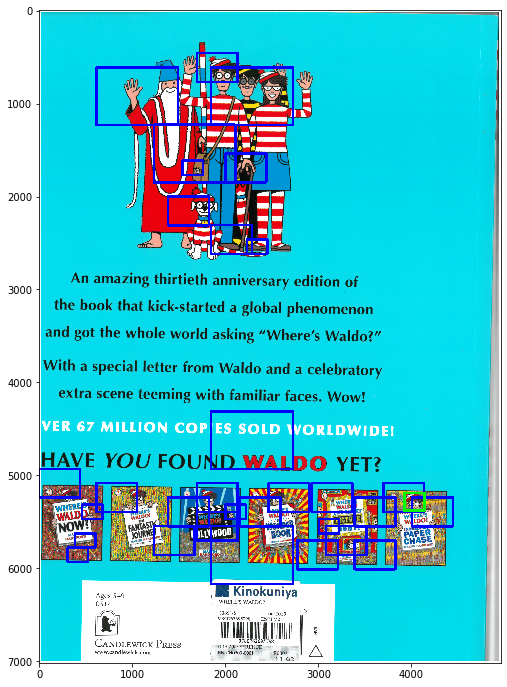

In [328]:
# Visualise detections
clone = example_full.copy()
for (x1, y1, x2, y2, score) in detections:
    cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 0, 255), thickness=25)
cv2.rectangle(clone, (ground_truth[0], ground_truth[1]), (ground_truth[2], ground_truth[3]), (0, 255, 0), thickness=25)
plt.imshow(clone)

In [383]:
# Perform Haar Cascade detection on detections
filtered_detections = haar_detection(example_full, detections, cascade_classifier)
print('Number of detections: ', len(filtered_detections))

Number of detections:  21


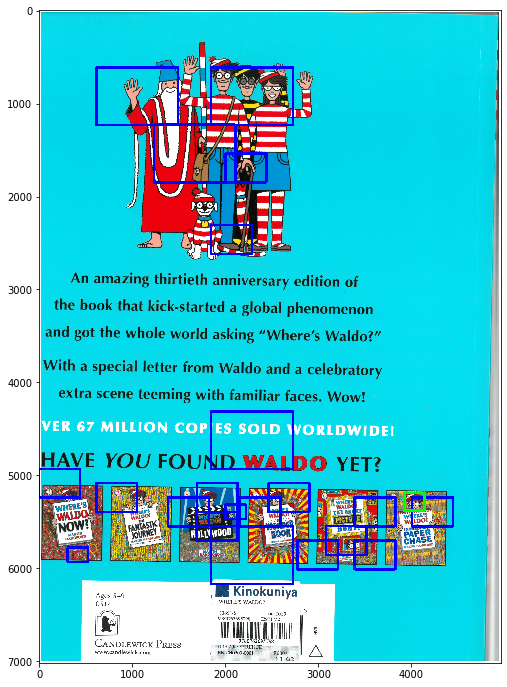

In [384]:
clone = example_full.copy()
for (x1, y1, x2, y2, score) in filtered_detections:
    cv2.rectangle(clone, (x1, y1), (x2, y2), (0, 0, 255), thickness=25)
cv2.rectangle(clone, (ground_truth[0], ground_truth[1]), (ground_truth[2], ground_truth[3]), (0, 255, 0), thickness=25)
plt.imshow(clone)